In [1]:
import numpy as np
import sklearn
#Import keras from tensorflow and not as a standalone thing (that makes things work weird idk why)
from tensorflow import keras
# CNN
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Conv1D, Activation, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import InputLayer, Dropout, LSTM, BatchNormalization, Flatten, ZeroPadding1D, AveragePooling2D, BatchNormalization, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
import pickle
#import helper_functions
from tensorflow.keras.layers import GlobalMaxPooling1D, Dropout, BatchNormalization


from sklearn.metrics import confusion_matrix

import seaborn as sns
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

In [2]:
data_path = 'data'
with open(data_path, 'rb') as f:
    data = pickle.Unpickler(f).load()

In [3]:
# Shuffle the data
dataToShuffle = []

for log, mfcc, label in zip(data['log-mel'],data['mfccs'],data['classes']):
    dataToShuffle.append([log,mfcc,label])

ShuffledData = np.array(dataToShuffle)
np.random.shuffle(ShuffledData)

In [4]:
# Separate the data into training and test datasets
Train = ShuffledData[:45305]
Test = ShuffledData[45305:]

log_train = []
mfcc_train = []
y_train = []

log_test = []
mfcc_test = []
y_test = []

for log, mfcc, label in Train:
    log_train.append(log)
    mfcc_train.append(mfcc)
    y_train.append(label)
    
for log, mfcc, label in Test:
    log_test.append(log)
    mfcc_test.append(mfcc)
    y_test.append(label)

In [10]:
InputShape = log_test[0].shape
output_dim = y_test[0].shape[0]

dropout = 0.2

#based on model 1 from https://www.researchgate.net/publication/348432098_Speech_recognition_based_on_Convolutional_neural_networks_and_MFCC_algorithm
# Getting around 80% accuracy
model = Sequential()

model.add(InputLayer(input_shape=InputShape))
model.add(ZeroPadding1D(padding=2))

model.add(Conv1D(filters=256, kernel_size=10))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(Conv1D(filters=256, kernel_size=10))
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(output_dim))
model.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Import new metrics 
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', recall, precision])

In [21]:
InputShape = log_test[0].shape
output_dim = y_test[0].shape[0]

dropout = 0.2

#based on model 1 from https://www.researchgate.net/publication/348432098_Speech_recognition_based_on_Convolutional_neural_networks_and_MFCC_algorithm
# Getting around 80% accuracy
model = Sequential()

model.add(InputLayer(input_shape=InputShape))
model.add(ZeroPadding1D(padding=2))

model.add(Conv1D(filters=256, kernel_size=10))
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(output_dim))
model.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Import new metrics 
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', recall, precision])

In [22]:
# Initiate early stopping callback (on validation set from training data 0.15)
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 3)
#Train the model 
x_train = np.array(mfcc_train)
y_train = np.array(y_train)
history = model.fit(x=x_train, y=y_train, epochs=12, batch_size=128, validation_split = 0.10, callbacks = [callback])

Epoch 1/12
319/319 [==============================] - 41s 58ms/step - loss: 26.4686 - accuracy: 0.5053 - recall_2: 0.5051 - precision_2: 0.5058 - val_loss: 11.5235 - val_accuracy: 0.6480 - val_recall_2: 0.6478 - val_precision_2: 0.6479
Epoch 2/12
319/319 [==============================] - 14s 44ms/step - loss: 6.9173 - accuracy: 0.6068 - recall_2: 0.6056 - precision_2: 0.6085 - val_loss: 4.6922 - val_accuracy: 0.6047 - val_recall_2: 0.6025 - val_precision_2: 0.6080
Epoch 3/12
319/319 [==============================] - 14s 43ms/step - loss: 4.6634 - accuracy: 0.6628 - recall_2: 0.6615 - precision_2: 0.6650 - val_loss: 3.4196 - val_accuracy: 0.7140 - val_recall_2: 0.7120 - val_precision_2: 0.7164
Epoch 4/12
319/319 [==============================] - 14s 44ms/step - loss: 3.7130 - accuracy: 0.6942 - recall_2: 0.6926 - precision_2: 0.6968 - val_loss: 3.0637 - val_accuracy: 0.6842 - val_recall_2: 0.6813 - val_precision_2: 0.6874
Epoch 5/12
319/319 [==============================] - 16s 49ms

In [23]:
# Save the model 
model.save('models\CNN')

# Save history object
file = open('models\CNN_history', 'wb')
pickle.dump(history.history,file)
file.close()

INFO:tensorflow:Assets written to: models\CNN\assets


In [24]:
# Load the model 
model = keras.models.load_model('models\CNN')


# Load the history object 
file = open('models\CNN_history', 'rb')
history = pickle.load(file)
file.close()

In [25]:
# Testing the model 1
x_test = np.array(mfcc_test)
y_test = np.array(y_test)
score = model.evaluate(x_test,y_test)

607/607 [==============================] - 3s 4ms/step - loss: 1.8476 - accuracy: 0.7925 - recall_2: 0.7909 - precision_2: 0.7961


In [26]:
# Model's prediction on the test data and the desired output
output = model.predict(x_test)
logits_pred = output.argmax(axis=1)
logits_test = y_test.argmax(axis=1)

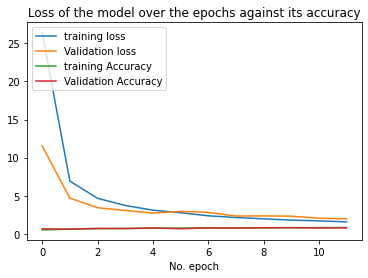

In [27]:
# Training/Validation Loss
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="Validation loss")
plt.plot(history['accuracy'], label="training Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")
plt.title('Loss of the model over the epochs against its accuracy')

plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

<AxesSubplot:>

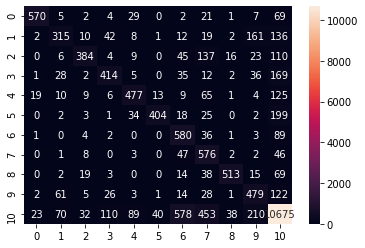

In [28]:
# Confusion matrix
cf_matrix = confusion_matrix(logits_test,logits_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g' )

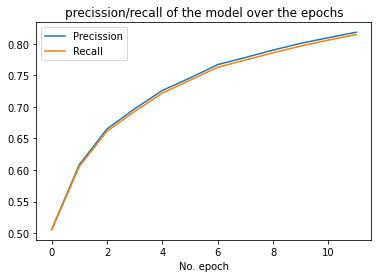

In [31]:
# Precision / Recall curve (training)
plt.plot(history['precision_2'], label="Precission")
plt.plot(history['recall_2'], label="Recall")
plt.title('precission/recall of the model over the epochs')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()